# TDA tests

### JMGB (01/27/2025)

Modified from Shaw Talebi's code (still largely unpolished/spaghetti-like)

In [1]:
# Do all of the imports and setup inline plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

from scipy.interpolate import InterpolatedUnivariateSpline

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from ripser import ripser
from persim import plot_diagrams
import yfinance as yf
from ripser import Rips
import persim

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from persim import PersLandscapeApprox

In [2]:
#%matplotlib ipympl

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### Changes: 

1. Increased date range
1. Pulled VIX data for later comparison

In [3]:
# define index names: ^GSPC = S&P 500, ^DJI = DOW Jones, ^IXIC=NASDAQ, ^RUT = Russell 2000
index_names = ['^GSPC', '^DJI', '^IXIC', '^RUT']

# define date range
start_date_string = "2004-01-01"
end_date_string = "2025-01-01"

# pull data from yahoo finance
raw_data = yf.download(index_names, start=start_date_string, end=end_date_string)
VIX = yf.download(['^VIX'], start=start_date_string, end=end_date_string)

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# keep only adjusted closing prices
df_close = raw_data['Adj Close'].dropna(axis='rows')

# define array of adjusted closing prices
P = df_close.to_numpy()
# define array of log-returns defined as the log of the ratio between closing values of two subsequent days
r = np.log(np.divide(P[1:],P[:len(P)-1]))

### Changes:

1. Set window size `w` to 15 days, but anywhere from 2-100 seems useable. Gidea and Katz seem to suggest 50 or 100, though I have not managed to replicate their work with $L_P$ norms (merits further investigation). 
1. Instead of calculating change in Wasserstein distance between adjacent (non-overlapping) windows), calculate the distance to some reference window indexed by `o`. For now, I picked one more or less randomly (`o=4000`) but this would ideally be the "representative" w-days window of the time series. 
1. Fixed data leakage - distances are assigned to the end of the window (but probably need to clean up overall indexing). 

In [5]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

# some parameters
w = 15 # time window size
n = len(raw_data)-(2*w)+1 # number of time segments
wasserstein_dists = np.zeros((n+w,1)) # initialize array for wasserstein distances
LPs = np.zeros((n+w,1))

# compute wasserstein distances between persistence diagrams for some reference period
o = 4000
dgm1 = rips.fit_transform(r[o:o+w]) 

for i in range(n-1):
    # Compute persistence diagrams for adjacent time windows
    dgm2 = rips.fit_transform(r[i+1:i+w+1])
    wasserstein_dists[i+w+1] = persim.wasserstein(dgm1[0], dgm2[0], matching=False)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


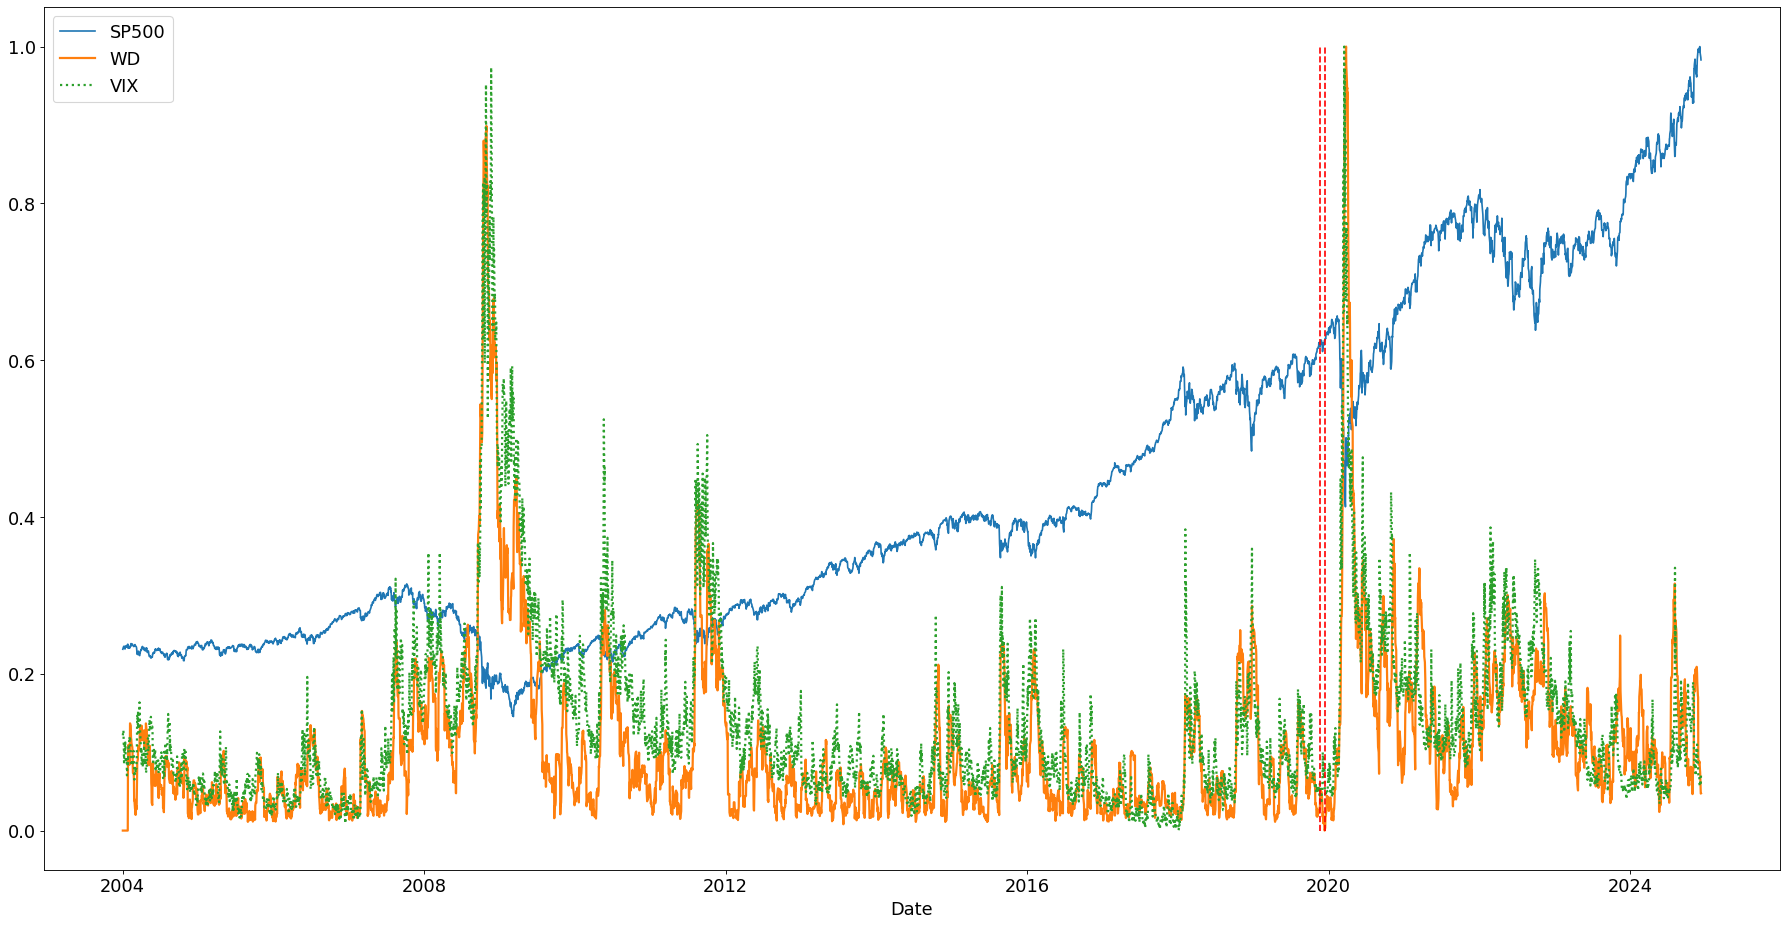

In [6]:
# plot wasserstein distances over time
plt.figure(figsize=(28, 14), dpi=80)
plt.rcParams.update({'font.size': 16})

s = 0
f = n+w

plt.plot(raw_data.index[s:f],df_close.iloc[s:f,0]/max(df_close.iloc[0:n+w,0]), label = 'SP500')
plt.plot(raw_data.index[s:f],wasserstein_dists[s:f]/np.max(wasserstein_dists[s:f]), label = 'WD', linewidth = 2)

vx = VIX.iloc[s:f,0]-np.min(VIX.iloc[s:f,0])
plt.plot(raw_data.index[s:f],vx/np.max(vx), label = 'VIX', linewidth = 2, linestyle = ':')

# This is just to show the reference window, make sure it is "representative" or at least not irregular. 
plt.plot([raw_data.index[o], raw_data.index[o]], [0, 1], 'r--')
plt.plot([raw_data.index[o+w], raw_data.index[o+w]], [0, 1], 'r--')

plt.legend()
plt.xlabel('Date')

plt.show()


# Other tests/Scratch

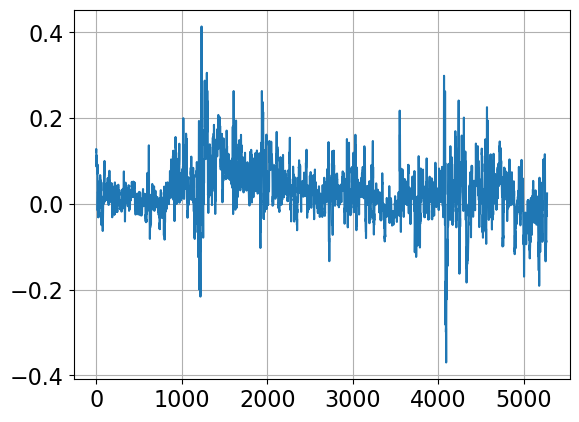

In [7]:
# Residual of VIX
a = vx/np.max(vx)
a = a.array.reshape((len(vx),1))
b = wasserstein_dists[s:f]/np.max(wasserstein_dists[s:f])

plt.plot(a - b)
plt.grid()
plt.show()

Testing other VIX forecasts

In [8]:
# define index names: ^GSPC = S&P 500, ^DJI = DOW Jones, ^IXIC=NASDAQ, ^RUT = Russell 2000
index_names = ['^GSPC', '^DJI', '^IXIC', '^RUT']

# define date range
start_date_string = "2014-01-01"
end_date_string = "2025-01-01"

# pull data from yahoo finance
raw_data = yf.download(index_names, start=start_date_string, end=end_date_string)
VIX = yf.download(['^VIX'], start=start_date_string, end=end_date_string)
VIX9 = yf.download(['^VIX9d'], start=start_date_string, end=end_date_string)
VIX90 = yf.download(['^VIX3m'], start=start_date_string, end=end_date_string)

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
# keep only adjusted closing prices
df_close = raw_data['Adj Close'].dropna(axis='rows')

# define array of adjusted closing prices
P = df_close.to_numpy()
# define array of log-returns defined as the log of the ratio between closing values of two subsequent days
r = np.log(np.divide(P[1:],P[:len(P)-1]))

In [10]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

# some parameters
w = 7 # time window size (set to around 7 or 60 for other VIX forecasts)
n = len(raw_data)-(2*w)+1 # number of time segments
wasserstein_dists = np.zeros((n+w,1)) # initialize array for wasserstein distances
LPs = np.zeros((n+w,1))

# compute wasserstein distances between persistence diagrams for some reference period
o = 600
dgm1 = rips.fit_transform(r[o:o+w]) 

for i in range(n-1):
    # Compute persistence diagrams for adjacent time windows
    dgm2 = rips.fit_transform(r[i+1:i+w+1])
    wasserstein_dists[i+w+1] = persim.wasserstein(dgm1[0], dgm2[0], matching=False)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


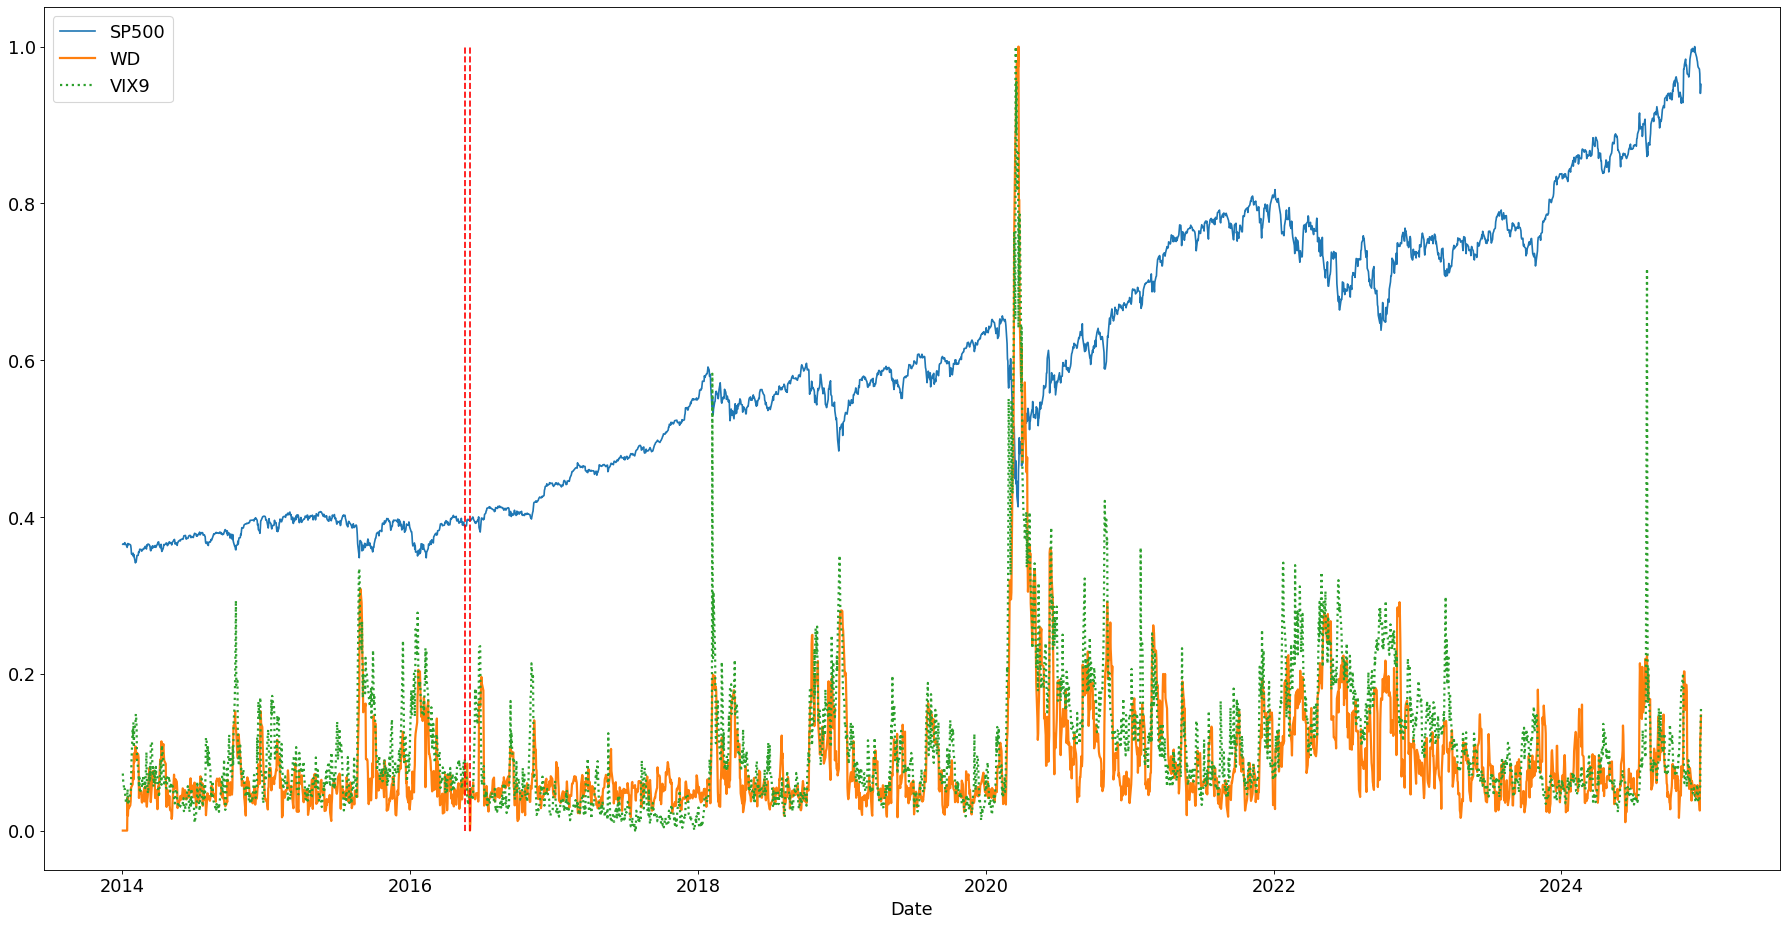

In [11]:
# plot wasserstein distances over time
plt.figure(figsize=(28, 14), dpi=80)
plt.rcParams.update({'font.size': 16})

s = 0
f = n+w

plt.plot(raw_data.index[s:f],df_close.iloc[s:f,0]/max(df_close.iloc[0:n+w,0]), label = 'SP500')
plt.plot(raw_data.index[s:f],wasserstein_dists[s:f]/np.max(wasserstein_dists[s:f]), label = 'WD', linewidth = 2)

vx9 = VIX9.iloc[s:f,0]-np.min(VIX9.iloc[s:f,0])
plt.plot(raw_data.index[s:f],vx9/np.max(vx9), label = 'VIX9', linewidth = 2, linestyle = ':')

vx90 = VIX90.iloc[s:f,0]-np.min(VIX90.iloc[s:f,0])
#plt.plot(raw_data.index[s:f],vx90/np.max(vx90), label = 'VIX90', linewidth = 2, linestyle = ':')

# This is just to show the reference window, make sure it is "representative" or at least not irregular. 
plt.plot([raw_data.index[o], raw_data.index[o]], [0, 1], 'r--')
plt.plot([raw_data.index[o+w], raw_data.index[o+w]], [0, 1], 'r--')

plt.legend()
plt.xlabel('Date')

plt.show()